In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, False)
import numpy as np

from nif.optimizers import AdaBeliefOptimizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import obspy
# plt.rc('text', usetex = True)
# plt.rc('font', family='serif')

2022-11-16 12:06:44.311740: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-16 12:06:46.872915: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-16 12:06:46.874429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-16 12:06:46.948899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.20GiB deviceMemoryBandwidth: 1.76TiB/s
2022-11-16 12:06:46.948977: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-16 12:06:46.967566: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2

1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras import initializers

In [3]:
DR_PATH = f"/fd1/yiyu_data/OOI/OOI-training-15min-demean-15-29-XMIN25000-XMAX40000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw'][::8,::8]
TRAIN_DATA -= TRAIN_DATA.min()
TRAIN_DATA /= abs(TRAIN_DATA).max()

In [6]:
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); X = x/(NX-1)
# T = t; X = x;
print(NX, NT)

1875 2250


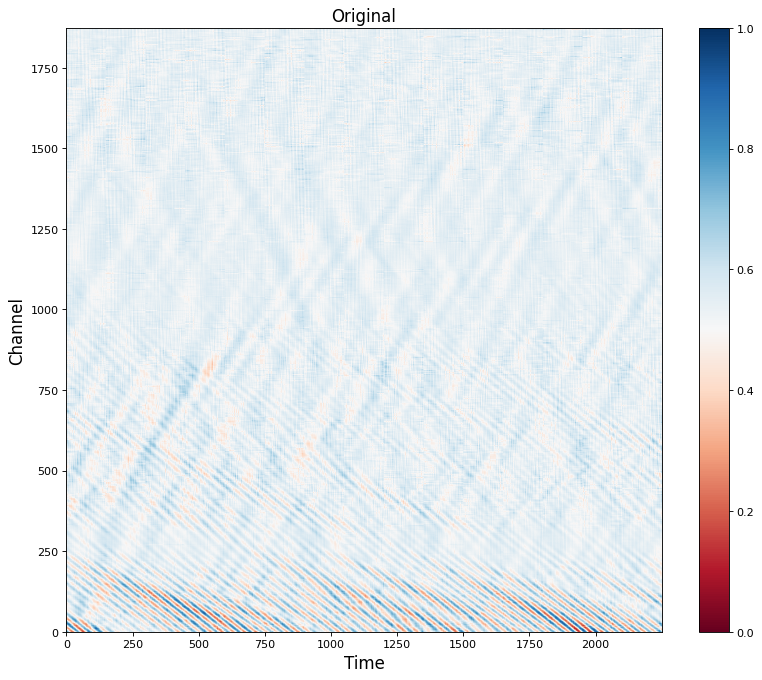

In [4]:
fig = plt.figure(figsize = (12, 10), dpi = 80)
plt.imshow(TRAIN_DATA[:, :], cmap = 'RdBu', aspect = 'auto', origin='lower')
plt.title("Original", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar()

In [7]:
transfer = False

if not transfer:
    # Gaussian
    nfeature = 196
    B = np.random.normal(scale = 20, size = (nfeature, 2))
    # nfeature = 2
    # B = np.eye(2)
    
    Bv = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)@B.T
    
test_data = np.concatenate([np.cos(2*np.pi*Bv), np.sin(2*np.pi*Bv), TRAIN_DATA.reshape([-1, 1])], axis = -1)
train_data = test_data[:, :]
print(test_data.shape)

(4218750, 393)


In [8]:
batch_size = 4096
# batch_size = 1024*16
num_total_data = train_data.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[:, :(train_data.shape[-1]-1)],
                                                    train_data[:, (train_data.shape[-1]-1)]))
train_dataset = train_dataset.shuffle(int(num_total_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2022-11-16 12:34:17.457531: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 12:34:17.474712: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-16 12:34:17.476661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.20GiB deviceMemoryBandwidth: 1.76TiB/s
2022-11-16 12:34:17.476806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-16 12:34:17.485365: I tensorflow/stream_executor/platfor

In [9]:
if not transfer:
    model = Sequential([
        Flatten(input_shape=(2*nfeature, )),
        Dense(nfeature, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)),   
        Dense(nfeature, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)),
        Dense(nfeature, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)),
        Dense(nfeature, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)),
        Dense(nfeature, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1)),
        Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.1)), 
    ])
    lr = 5e-4
    optimizer = tf.keras.optimizers.Adam(lr)
    # optimizer = AdaBeliefOptimizer(lr)
    model.compile(optimizer=optimizer, loss='mse')
else:
    optimizer.learning_rate.assign(3e-4)
    
history_callback = tf.keras.callbacks.History()
callbacks = [history_callback]

nweights = 0
for i in model.get_weights():
    nweights += len(i.flatten())
print(f"have total {nweights}")

have total 231673


In [10]:
model.fit(train_dataset, epochs=12, callbacks=callbacks, 
          use_multiprocessing = True, shuffle = False)

2022-11-16 12:34:51.657608: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13230000000 exceeds 10% of free system memory.
2022-11-16 12:35:00.935722: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13230000000 exceeds 10% of free system memory.


Epoch 1/12


2022-11-16 12:35:13.199101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-16 12:35:13.218253: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000000000 Hz
2022-11-16 12:35:13.328576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-16 12:35:23.314497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1743479 of 4218750


   5/1030 [..............................] - ETA: 35s - loss: 0.0379  

2022-11-16 12:35:33.105661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 63s 41ms/step - loss: 0.0044


2022-11-16 12:36:15.210027: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13230000000 exceeds 10% of free system memory.


Epoch 2/12


2022-11-16 12:36:33.324898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3052534 of 4218750


   4/1030 [..............................] - ETA: 43s - loss: 0.0013  

2022-11-16 12:36:37.381500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 59s 44ms/step - loss: 0.0012


2022-11-16 12:37:22.565979: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13230000000 exceeds 10% of free system memory.


Epoch 3/12


2022-11-16 12:37:39.586261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1748592 of 4218750
2022-11-16 12:37:49.586209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4116793 of 4218750


   6/1030 [..............................] - ETA: 26s - loss: 9.7333e-04  

2022-11-16 12:37:49.943802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 58s 36ms/step - loss: 9.5564e-04
Epoch 4/12


2022-11-16 12:38:41.534186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2444412 of 4218750


   5/1030 [..............................] - ETA: 36s - loss: 9.1629e-04  

2022-11-16 12:38:48.893622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 80s 60ms/step - loss: 8.9664e-04
Epoch 5/12


2022-11-16 12:40:10.095533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2962424 of 4218750


   5/1030 [..............................] - ETA: 40s - loss: 8.7376e-04  

2022-11-16 12:40:14.053749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 53s 38ms/step - loss: 8.6339e-04
Epoch 6/12


2022-11-16 12:41:11.331992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3123452 of 4218750


   5/1030 [..............................] - ETA: 31s - loss: 8.1940e-04  

2022-11-16 12:41:14.598801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 61s 46ms/step - loss: 8.4656e-04
Epoch 7/12


2022-11-16 12:42:16.342147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3163340 of 4218750


   7/1030 [..............................] - ETA: 21s - loss: 8.3265e-04  

2022-11-16 12:42:19.279797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 44s 30ms/step - loss: 8.2992e-04
Epoch 8/12


2022-11-16 12:43:03.765531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3069611 of 4218750


   4/1030 [..............................] - ETA: 49s - loss: 8.1473e-04  

2022-11-16 12:43:07.603842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 55s 40ms/step - loss: 8.1305e-04
Epoch 9/12


2022-11-16 12:44:01.644603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3975386 of 4218750


   7/1030 [..............................] - ETA: 28s - loss: 7.9481e-04

2022-11-16 12:44:02.251490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 40s 29ms/step - loss: 8.0475e-04
Epoch 10/12


2022-11-16 12:44:44.007749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3674746 of 4218750


   2/1030 [..............................] - ETA: 1:05 - loss: 8.0151e-04   

2022-11-16 12:44:46.073576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 51s 38ms/step - loss: 7.9490e-04
Epoch 11/12


2022-11-16 12:45:46.439873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3889983 of 4218750


   6/1030 [..............................] - ETA: 32s - loss: 7.8963e-04  

2022-11-16 12:45:47.189374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 51s 39ms/step - loss: 7.8538e-04
Epoch 12/12


2022-11-16 12:46:44.526831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4069443 of 4218750


   5/1030 [..............................] - ETA: 31s - loss: 7.6831e-04  

2022-11-16 12:46:44.973150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


1030/1030 [==============================] - 42s 31ms/step - loss: 7.7771e-04


In [88]:
if not transfer:
    print("first time training, not transfer")
    first_time_weights = model.get_weights()
    first_time_train = history_callback.history['loss']
else:
    print("transfer to another dataset")
    second_time_train = history_callback.history['loss']

first time training, not transfer


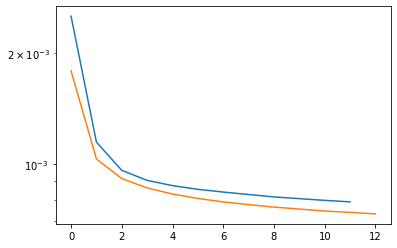

In [89]:
plt.plot(first_time_train)
plt.plot(second_time_train)
plt.gca().set_yscale('log')

([], [])

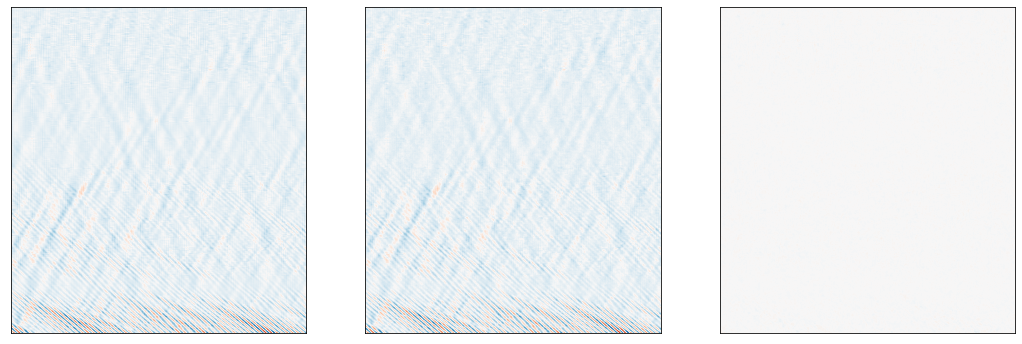

In [91]:
predict = np.array(model.predict(test_data[:, :-1])).reshape([NX, NT])
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -1, vmax = 1)
plt.xticks([]); plt.yticks([])
plt.colorbar()
# plt.title("residual", fontsize = 20)
# plt.savefig("rft-deep.pdf", bbox_inches = 'tight')

Text(0.5, 0, 'Channel')

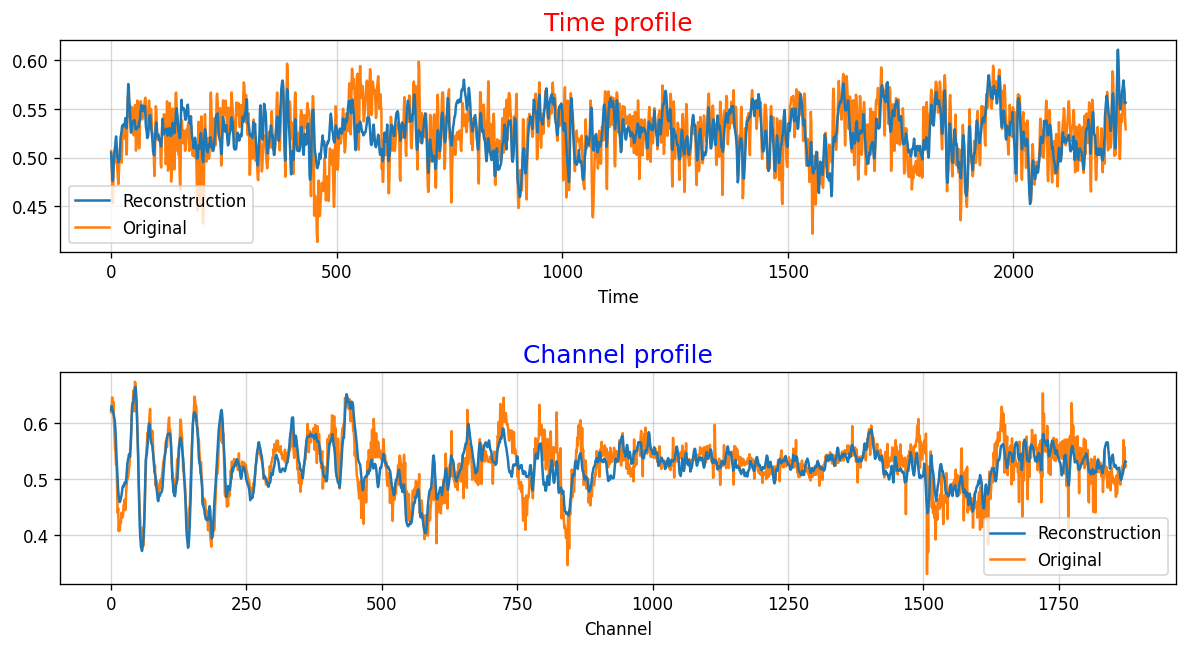

In [186]:
IX = 1000; IT = 1000;
x = np.arange(NX)/(NX-1)
t = np.arange(NT)/(NT-1)

fig = plt.figure(figsize = (12, 6), dpi = 120)
plt.subplots_adjust(hspace = 0.57)
plt.subplot(2, 1, 1)

d = np.stack([t, x[IX] * np.ones(int(NT))], axis = -1)@B.T
d = np.concatenate([np.cos(2*np.pi*d), np.sin(2*np.pi*d)], axis = -1)
aa = model.predict(d).reshape(1, int(NT), 1)[:, :, 0]

plt.plot(aa.T, label = 'Reconstruction', zorder = 9)
plt.plot(TRAIN_DATA[IX, :], label = 'Original')

# plt.plot(np.diff(aa)[0], label = 'Gradient Reconstruction', zorder = 9)
# plt.plot(np.diff(TRAIN_DATA[IX, :]), label = 'Gradient Original')

plt.grid(True, alpha = 0.5)
plt.title("Time profile", fontsize = 15, color = 'red')
plt.legend(fontsize = 10)
plt.xlabel("Time", fontsize = 10)

plt.subplot(2, 1, 2)
d = np.stack([t[IT]* np.ones(int(NX)), x], axis = -1)@B.T
d = np.concatenate([np.cos(2*np.pi*d), np.sin(2*np.pi*d)], axis = -1)
bb = model.predict(d).reshape(1, int(NX), 1)[:, :, 0]

plt.plot(bb.T, label = 'Reconstruction', zorder = 9)
plt.plot(TRAIN_DATA[:, IT], label = 'Original')

# # plt.plot(np.diff(bb)[0], label = 'Gradient Reconstruction', zorder = 90)
# # plt.plot(np.diff(TRAIN_DATA[::DNX, IT]), label = 'Gradient Original')

plt.legend(loc = 'upper right')
plt.grid(True, alpha = 0.5)
plt.title("Channel profile", fontsize = 15, color = 'blue')
plt.legend(fontsize = 10)
plt.xlabel("Channel", fontsize = 10)

# plt.savefig(f"./profile.pdf", bbox_inches = 'tight', dpi = 300)
# plt.close()

In [22]:
nnx = TRAIN_DATA.shape[0]
nns = TRAIN_DATA.shape[1]
dx = 2.0419047
dt = 1/20
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=5*dt))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=5*dx))

# Calculate the frequency-wavenumber spectrum
ft2_resc = np.fft.fftshift(np.fft.fft2(predict))
ft2_resc = np.log10(abs(ft2_resc)) # this is not normalized

ft2_orig = np.fft.fftshift(np.fft.fft2(TRAIN_DATA))
ft2_orig = np.log10(abs(ft2_orig)) # this is not normalized

(-0.01, 0.01)

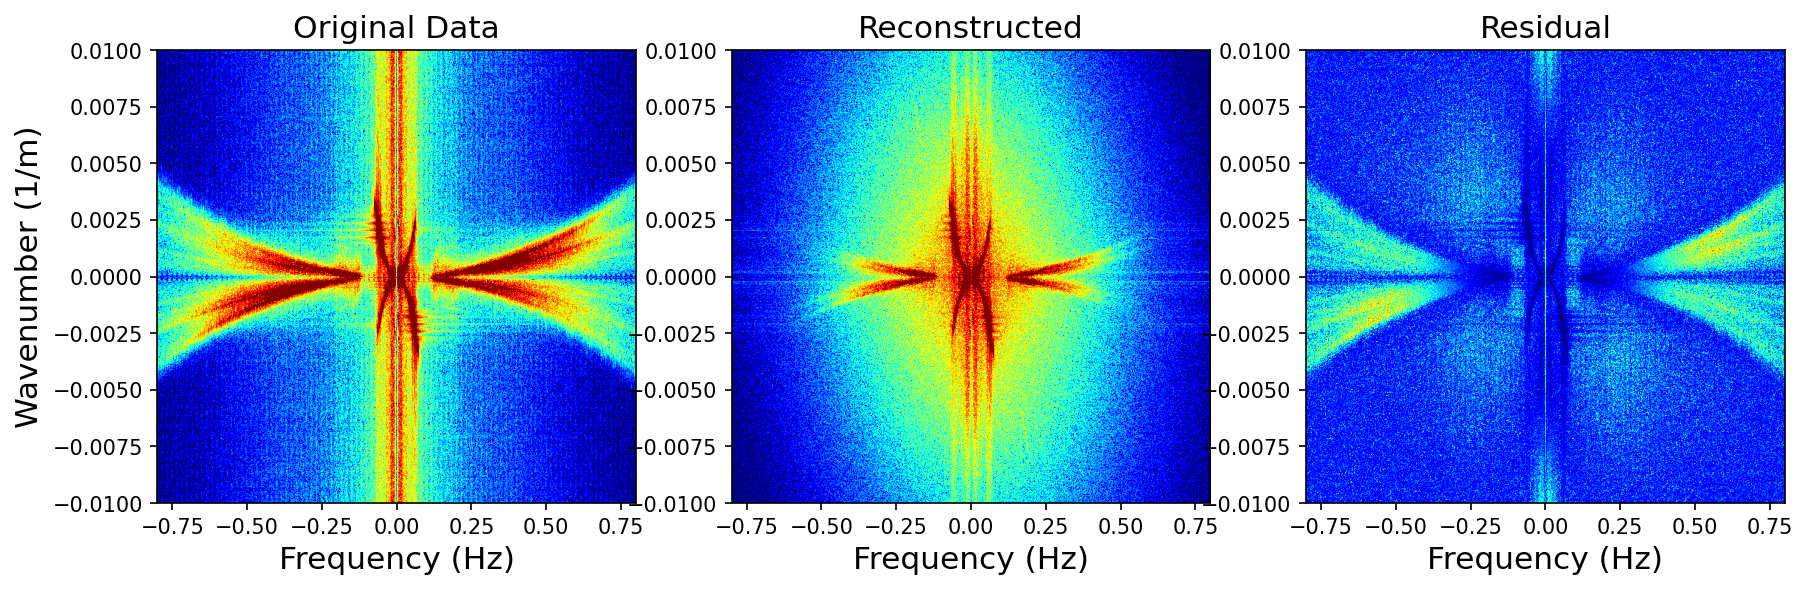

In [23]:
xlim = [-0.8, 0.8]; ylim = [-0.01,0.01]
plt.figure(figsize= (14, 4), dpi = 150)
plt.subplot(1,3,1)
plt.imshow(np.abs(ft2_orig), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], 
           vmin=1,vmax=3)
plt.title("Original Data", fontsize = 15)
plt.ylabel("Wavenumber (1/m)", fontsize = 15)
plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(1,3,2)
plt.imshow(np.abs(ft2_resc), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], 
           vmin=1,vmax=3)
# plt.colorbar()
plt.title("Reconstructed", fontsize = 15)
plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(1,3,3)
plt.imshow(np.abs(ft2_orig-ft2_resc), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], vmax = 2)
# plt.colorbar(location = 'bottom')
plt.title("Residual", fontsize = 15)
plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)

# plt.savefig(f"./fk_res.pdf", bbox_inches = 'tight', dpi = 150)
# plt.close()

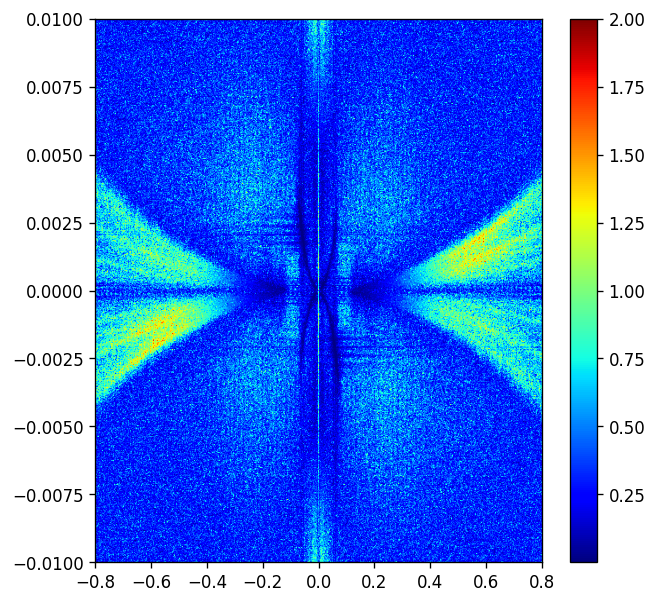

In [26]:
plt.figure(figsize= (6, 6), dpi = 120)
plt.imshow(np.abs(ft2_orig-ft2_resc), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], vmax = 2)
plt.colorbar(location = 'right')
# plt.title("Residual", fontsize = 15)
# plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)
plt.savefig("rft-deep-fk.pdf", bbox_inches = 'tight')

(-0.005, 0.005)

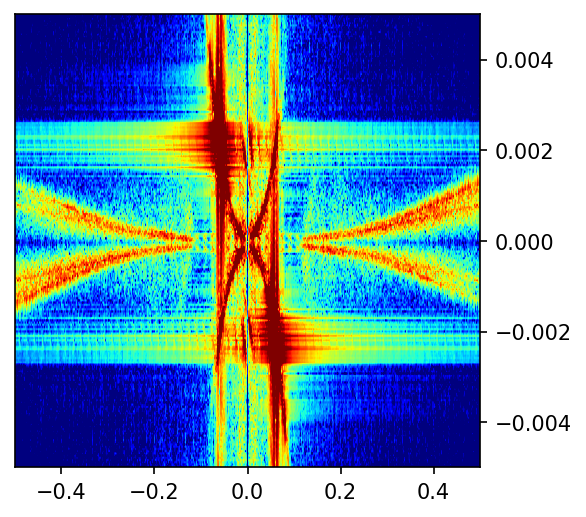

In [31]:
xlim = [-0.5, 0.5]; ylim = [-0.005,0.005]
plt.figure(figsize= (4, 4), dpi = 150)
plt.imshow(np.abs(ft2_orig), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], 
           vmin=1,vmax=3)
# plt.ylabel("Wavenumber (1/m)", fontsize = 15)
# plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.xlim(xlim)
plt.ylim(ylim)